# Описание проекта

Банку необходимо по данным клиентов предсказать, кто из них в ближайшее время захочет расторгнуть договор.

Для этого нужно построить модель классификации со  значением *F1*-меры не менее 0.59.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


# Используемые библиотеки

Pandas, numpy, matplotlib, sklearn

## План исследования

1. Подготовка данных
2. Исследование задачи
3. Борьба с дисбалансом
4. Тестирование модели
5. Проверка модели на адекватность
6. Общий вывод

# 1. Подготовка данных <a id='section1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('once')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 19

In [2]:
df = pd.read_csv('Churn.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Необходимо выполнить следующие действия:
* Перевести все числовые значения в int32
* Убрать столбец с фамилиями
* Перевести категориальные признаки в численные
* Заполнить пропуски в Tenure

##### Изменим типы данных

In [3]:
columns_to_int32 = ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 
                    'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

# Временно заполним пропуски в Tenure минус единицами
df['Tenure'] = df['Tenure'].fillna(-1)

for column in columns_to_int32:
    df[column] =  df[column].astype('int32')

##### Уберем столбец с фамилиями

In [4]:
df = df.drop(['Surname'] , axis=1)

##### Переведем категориальные признаки в численные

In [5]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'],drop_first=True)
df.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2,0,1,1,1,101348,1,0,0,0
1,2,15647311,608,41,1,83807,1,0,1,112542,0,0,1,0
2,3,15619304,502,42,8,159660,3,1,0,113931,1,0,0,0
3,4,15701354,699,39,1,0,2,0,0,93826,0,0,0,0
4,5,15737888,850,43,2,125510,1,1,1,79084,0,0,1,0


##### Заполним пропуски в Tenure

In [6]:
# Отделим заполненные значения
df_pos = df.query('Tenure >= 0')

Для заполнения напишем функцию, которая для каждого пропуска будет искать людей с такими же полом, возрастом, страной. После этого функция будет находить медиану количества недвижимости в найденых строках и вставлять ее вместо пропуска.

In [7]:
def fill_pass(pas):
    for i in range(len(df)):
        if df.loc[i, pas] < 0: # Выбирает пропущенные значения

            df.loc[i, pas] = (           # Присваиваем пропуску значение
                df_pos[
                    (df_pos['Age'] == df.loc[i, 'Age']) & 
                    (df_pos['Geography_Germany'] == df.loc[i, 'Geography_Germany']) & 
                    (df_pos['Geography_Spain'] == df.loc[i, 'Geography_Spain']) & 
                    (df_pos['Gender_Male'] == df.loc[i, 'Gender_Male'])
                ]
                [pas].median()   # Берем медиану искмой характеристики из найденных строк
            )

# Запускаем функцию 
fill_pass('Tenure')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RowNumber          10000 non-null  int32  
 1   CustomerId         10000 non-null  int32  
 2   CreditScore        10000 non-null  int32  
 3   Age                10000 non-null  int32  
 4   Tenure             9997 non-null   float64
 5   Balance            10000 non-null  int32  
 6   NumOfProducts      10000 non-null  int32  
 7   HasCrCard          10000 non-null  int32  
 8   IsActiveMember     10000 non-null  int32  
 9   EstimatedSalary    10000 non-null  int32  
 10  Exited             10000 non-null  int32  
 11  Geography_Germany  10000 non-null  uint8  
 12  Geography_Spain    10000 non-null  uint8  
 13  Gender_Male        10000 non-null  uint8  
dtypes: float64(1), int32(10), uint8(3)
memory usage: 498.2 KB


Осталось всего 3 пропуска. Удалим строки с пропусками. 

In [8]:
df = df.dropna()

# Округлим данные и поменяем тип
df['Tenure'] = df['Tenure'].round().astype('int32')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   RowNumber          9997 non-null   int32
 1   CustomerId         9997 non-null   int32
 2   CreditScore        9997 non-null   int32
 3   Age                9997 non-null   int32
 4   Tenure             9997 non-null   int32
 5   Balance            9997 non-null   int32
 6   NumOfProducts      9997 non-null   int32
 7   HasCrCard          9997 non-null   int32
 8   IsActiveMember     9997 non-null   int32
 9   EstimatedSalary    9997 non-null   int32
 10  Exited             9997 non-null   int32
 11  Geography_Germany  9997 non-null   uint8
 12  Geography_Spain    9997 non-null   uint8
 13  Gender_Male        9997 non-null   uint8
dtypes: int32(11), uint8(3)
memory usage: 536.9 KB


#### Вывод:
Пропуски заполнены, данные приведены к нужным типам, категориальные признаки переведены в численные.

# 2. Исследование задачи <a id='section2'></a>

Проверим баланс классов

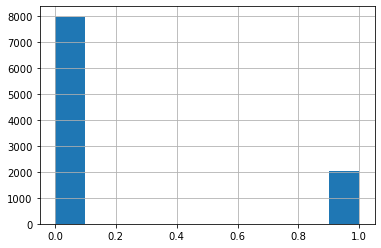

In [9]:
df['Exited'].hist()

Обнаружен явный дисбаланс. Значения отличаются примерно в 4 раза. В дальнейшем с ним нужно будет бороться. Пока выберем переспективную модель. 

#### Разделим данные на тренировочные, валидационные и тестовые в соотношении 0.6, 0.2, 0.2.

In [10]:
features = df.drop(['Exited', 'RowNumber', 'CustomerId'], axis=1)
target = df['Exited']


features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(5997, 11)
(2000, 11)
(2000, 11)


In [11]:
features_train.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

#### Дерево решений

In [12]:
# Напишем цикл, перебирающий параметры и записывающий их вместе с результатом в таблицу

tree_parameters = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'min_samples_leaf', 'f1'])

for depth in range(2, 21, 2):
    for split in range(2, 5):
        for leaf in range(1, 5):
            model = DecisionTreeClassifier(min_samples_split=split, min_samples_leaf=leaf, max_depth=depth, random_state=12345)
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)

            f1 = f1_score(target_valid, predictions_valid)
            
            result = pd.DataFrame([[depth, split, leaf, f1]])
            result.columns = ['max_depth', 'min_samples_split', 'min_samples_leaf', 'f1']
            tree_parameters = tree_parameters.append(result)

tree_parameters.sort_values(by=['f1'], ascending=False).head()

,max_depth,min_samples_split,min_samples_leaf,f1
0,8,4,4,0.600289
0,8,3,4,0.600289
0,8,2,4,0.600289
0,6,4,4,0.593607
0,6,2,4,0.593607


Наибольший показатель F1 равный 0.598 получен при параметрах дерева max_depth=8, min_samples_split=2, min_samples_leaf=4

#### Случайный лес

Следующая ячейка закомментирована, чтобы не тратить повторно время на ее вычисление.

In [13]:
# forest_parameters = pd.DataFrame(
#     columns=['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'f1'])

# for estim in range(10, 101, 10):
#     for depth in range(2, 21, 2):
#         for split in range(2, 5):
#             for leaf in range(1, 5):
#                 model = RandomForestClassifier(
#                     n_estimators=estim,
#                     min_samples_split=split, 
#                     min_samples_leaf=leaf, 
#                     max_depth=depth, 
#                     random_state=12345)
                
#                 model.fit(features_train, target_train)
#                 predictions_valid = model.predict(features_valid)

#                 f1 = f1_score(target_valid, predictions_valid)
            
#                 result = pd.DataFrame([[depth, split, leaf, estim, f1]])
#                 result.columns = ['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'f1']
#                 forest_parameters = forest_parameters.append(result)

In [14]:
# forest_parameters.sort_values(by=['f1'], ascending=False).head()

Наибольший показатель F1 равный 0.619 получен при параметрах леса max_depth=16, min_samples_split=4, min_samples_leaf=1, n_estimators=60

#### Логистическая регрессия

In [15]:
# Составим список возведений 10 в степени от -4 до 4, с шагом в 0,5
exp = np.logspace(-4, 4, num=17, endpoint=True, base=10.0)

for e in exp:
    model = LogisticRegression(C=e, solver='liblinear', random_state=12345)
    model.fit(features_train, target_train)
    
    predictions_valid = model.predict(features_valid)

    f1 = f1_score(target_valid, predictions_valid)
    print("C = 10^(",np.log10(e), ") : ", f1, sep='')

C = 10^(-4.0) : 0.09565217391304347
C = 10^(-3.5) : 0.10322580645161289
C = 10^(-3.0) : 0.11063829787234042
C = 10^(-2.5) : 0.11063829787234042
C = 10^(-2.0) : 0.11063829787234042
C = 10^(-1.5) : 0.11063829787234042
C = 10^(-1.0) : 0.11063829787234042
C = 10^(-0.5) : 0.11040339702760085
C = 10^(0.0) : 0.11063829787234042
C = 10^(0.5) : 0.11063829787234042
C = 10^(1.0) : 0.11063829787234042
C = 10^(1.5) : 0.11063829787234042
C = 10^(2.0) : 0.11063829787234042
C = 10^(2.5) : 0.11063829787234042
C = 10^(3.0) : 0.11063829787234042
C = 10^(3.5) : 0.11063829787234042
C = 10^(4.0) : 0.11063829787234042


Наибольший показатель F1 равный 0.114 получен при параметре С=0.01

#### Вывод:
Самое высокое значение F1 равное 0.619 получила модель случайного леса. Параметры модели:

max_depth = 16

min_samples_split = 4

min_samples_leaf = 1

n_estimators = 60

Далее будем проверять ее при отсутствии дисбаланса. 

# 3. Борьба с дисбалансом <a id='section3'></a>

#### Сбалансируем веса параметром class_weight

In [16]:
model = RandomForestClassifier(
    n_estimators=60,
    min_samples_split=4, 
    min_samples_leaf=1, 
    max_depth=16, 
    random_state=12345,
    class_weight='balanced')

model.fit(features_train, target_train)
    
predictions_valid = model.predict(features_valid)

f1 = f1_score(target_valid, predictions_valid)
print(f1)

0.6312769010043042


После добавления парамета class_weight='balanced' значение F1 немного уменьшилось.
Далее попробуем устранить дисбаланс методами upsampling и downsampling.

#### Исслудуем важность факторов <a id='answer2'></a>

Text(0.5, 1.0, 'Важность факторов')

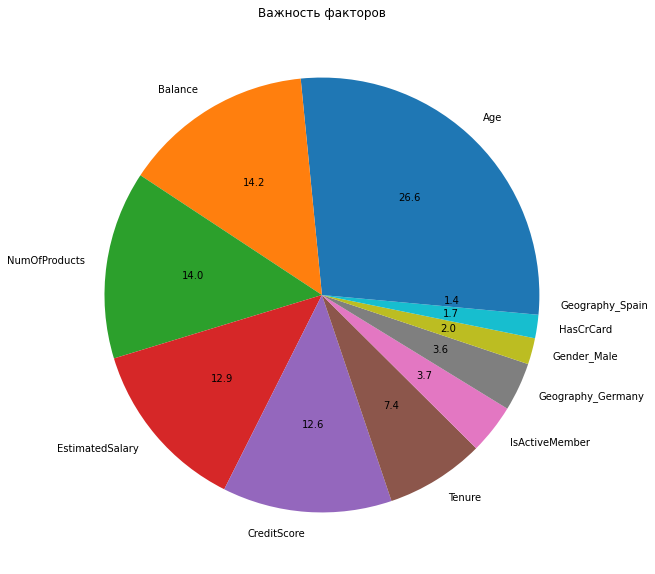

In [17]:
importances = pd.DataFrame(columns=['factor', 'importance'])
importances['factor'] = features.columns
importances['importance'] = model.feature_importances_
importances = importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,10))
plt.pie(importances['importance'], labels=importances['factor'], autopct='%.1f')
plt.title('Важность факторов')

Исследование показало, что самыми важными факторами являются возраст, баланс на счете, количество продуктов, кредитная история и предполагаемый доход. Самые малозначимые факторы: страна проживания, пол и наличие кредитной карты. Количество недвижимости не в списке самых важных факторов, но отказываться от него все-таки нельзя. 

#### Используем метод upsampling

In [18]:
from sklearn.utils import shuffle

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = RandomForestClassifier(
    n_estimators=60,
    min_samples_split=4, 
    min_samples_leaf=1, 
    max_depth=16, 
    random_state=12345)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

model = RandomForestClassifier(
    n_estimators=60,
    min_samples_split=4, 
    min_samples_leaf=1, 
    max_depth=16, 
    random_state=12345,
    class_weight='balanced')

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("Balanced F1:", f1_score(target_valid, predicted_valid))

F1: 0.6243523316062175
Balanced F1: 0.6367137355584083


Методом upsampling удалось достичь значения F1 0.637

#### Используем метод downsampling

In [19]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [20]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [21]:
model = RandomForestClassifier(
    n_estimators=60,
    min_samples_split=4, 
    min_samples_leaf=1, 
    max_depth=16, 
    random_state=12345)

model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

model = RandomForestClassifier(
    n_estimators=60,
    min_samples_split=4, 
    min_samples_leaf=1, 
    max_depth=16, 
    random_state=12345,
    class_weight='balanced')

model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("Balanced F1:", f1_score(target_valid, predicted_valid))

F1: 0.5771324863883848
Balanced F1: 0.578853046594982


#### Подберем значение порога для метода upsampling

In [22]:
model = RandomForestClassifier(
    n_estimators=60,
    min_samples_split=4, 
    min_samples_leaf=1, 
    max_depth=16, 
    random_state=12345,
    class_weight='balanced')

model.fit(features_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=4, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

In [23]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [24]:
for threshold in np.arange(0.3, 0.7, 0.01):
    predicted_valid = probabilities_one_valid > threshold

    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | F1 = {:.3f}".format(
        threshold, f1))

Порог = 0.30 | F1 = 0.561
Порог = 0.31 | F1 = 0.569
Порог = 0.32 | F1 = 0.577
Порог = 0.33 | F1 = 0.587
Порог = 0.34 | F1 = 0.595
Порог = 0.35 | F1 = 0.604
Порог = 0.36 | F1 = 0.603
Порог = 0.37 | F1 = 0.606
Порог = 0.38 | F1 = 0.615
Порог = 0.39 | F1 = 0.615
Порог = 0.40 | F1 = 0.619
Порог = 0.41 | F1 = 0.620
Порог = 0.42 | F1 = 0.619
Порог = 0.43 | F1 = 0.618
Порог = 0.44 | F1 = 0.618
Порог = 0.45 | F1 = 0.615
Порог = 0.46 | F1 = 0.621
Порог = 0.47 | F1 = 0.621
Порог = 0.48 | F1 = 0.623
Порог = 0.49 | F1 = 0.632
Порог = 0.50 | F1 = 0.637
Порог = 0.51 | F1 = 0.629
Порог = 0.52 | F1 = 0.633
Порог = 0.53 | F1 = 0.635
Порог = 0.54 | F1 = 0.632
Порог = 0.55 | F1 = 0.632
Порог = 0.56 | F1 = 0.626
Порог = 0.57 | F1 = 0.625
Порог = 0.58 | F1 = 0.627
Порог = 0.59 | F1 = 0.618
Порог = 0.60 | F1 = 0.615
Порог = 0.61 | F1 = 0.612
Порог = 0.62 | F1 = 0.606
Порог = 0.63 | F1 = 0.596
Порог = 0.64 | F1 = 0.586
Порог = 0.65 | F1 = 0.578
Порог = 0.66 | F1 = 0.571
Порог = 0.67 | F1 = 0.562
Порог = 0.68

Оптимальное значение порога 0.48

#### Подберем значение порога для логистической регрессии при использовании метода upsampling

На всякий случай. Вдруг логистическая регрессия тоже хорошо себя покажет. 

In [25]:
model = LogisticRegression(C=0.01, solver='liblinear', random_state=12345)
model.fit(features_upsampled, target_upsampled)
    
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.3, 0.7, 0.01):
    predicted_valid = probabilities_one_valid > threshold

    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | F1 = {:.3f}".format(
        threshold, f1))

Порог = 0.30 | F1 = 0.359
Порог = 0.31 | F1 = 0.360
Порог = 0.32 | F1 = 0.363
Порог = 0.33 | F1 = 0.368
Порог = 0.34 | F1 = 0.375
Порог = 0.35 | F1 = 0.381
Порог = 0.36 | F1 = 0.386
Порог = 0.37 | F1 = 0.388
Порог = 0.38 | F1 = 0.388
Порог = 0.39 | F1 = 0.395
Порог = 0.40 | F1 = 0.402
Порог = 0.41 | F1 = 0.406
Порог = 0.42 | F1 = 0.409
Порог = 0.43 | F1 = 0.418
Порог = 0.44 | F1 = 0.421
Порог = 0.45 | F1 = 0.429
Порог = 0.46 | F1 = 0.431
Порог = 0.47 | F1 = 0.430
Порог = 0.48 | F1 = 0.438
Порог = 0.49 | F1 = 0.438
Порог = 0.50 | F1 = 0.436
Порог = 0.51 | F1 = 0.446
Порог = 0.52 | F1 = 0.450
Порог = 0.53 | F1 = 0.446
Порог = 0.54 | F1 = 0.453
Порог = 0.55 | F1 = 0.455
Порог = 0.56 | F1 = 0.456
Порог = 0.57 | F1 = 0.459
Порог = 0.58 | F1 = 0.456
Порог = 0.59 | F1 = 0.443
Порог = 0.60 | F1 = 0.424
Порог = 0.61 | F1 = 0.411
Порог = 0.62 | F1 = 0.405
Порог = 0.63 | F1 = 0.398
Порог = 0.64 | F1 = 0.388
Порог = 0.65 | F1 = 0.370
Порог = 0.66 | F1 = 0.364
Порог = 0.67 | F1 = 0.347
Порог = 0.68

Самое высокое значение F1 получилось 0.462, что значительно меньше, чем у случайного леса. Далее будем рассматривать только его.

#### Вывод:
Наилучший результат (F1 = 0.638), достигнут случайным лесом при использовании методов upsampling и class_weight='balanced', а также при значении порога 0.48

# 4. Тестирование модели <a id='section4'></a>

#### Обучим модель случайного леса на тренировочных и валидационных данных

In [26]:
# Объединим данные
features = features_train.append(features_valid)
target = target_train.append(target_valid)

target.value_counts()

0    6381
1    1616
Name: Exited, dtype: int64

Значения также отличаются почти в 4 раза 

#### Используем метод upsampling

In [27]:
features_upsampled, target_upsampled = upsample(features, target, 4)

target_upsampled.value_counts()

1    6464
0    6381
Name: Exited, dtype: int64

In [28]:
model = RandomForestClassifier(
    n_estimators=60,
    min_samples_split=4, 
    min_samples_leaf=1, 
    max_depth=16, 
    random_state=12345,
    class_weight='balanced')

model.fit(features, target)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

predicted_test = probabilities_one_test > 0.48

f1 = f1_score(target_test, predicted_test)

print("F1 = {:.3f}".format(f1))

F1 = 0.608


#### Вывод:
Модель обучена на валидационной и тренировочной выборке. Далее модель была протестированна на тестовой выборке. Значение F1 на тестовой выборке 0.608. Результат получен при устранении дисбаланса методом upsampling и выборе значения порога в 0.48. 

# 5. Проверка модели на адекватность <a id='section5'></a>

Чтобы проверить нашу модель на адекватность, нужно сравнить ее AUC_ROC, с AUC_ROC при подстановке наиболее популярного значения (в нашем случае 0). 

In [29]:
from sklearn.metrics import roc_auc_score

In [30]:
# создадим последовательность из нулей по длине равную target_test
check = target_test * 0

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("AUC_ROC модели = {:.3f}".format(auc_roc))


auc_roc = roc_auc_score(target_test, check)

print("AUC_ROC при нулях = {:.3f}".format(auc_roc))

AUC_ROC модели = 0.860
AUC_ROC при нулях = 0.500


#### Вывод:
Проверка на адекватность показала, что предсказания модели значительно точнее подстановки популярного значения. 

AUC_ROC модели = 0.860

AUC_ROC при нулях = 0.500

# 6. Общий вывод <a id='section6'></a>

При изучении данных было обнаружено, что есть пропуски в столбце Tenure (количество недвижимости). Пропуски были заполнены округленными до целых чисел медианами среди похожих клиентов (пол, возраст, страна). Также категориальные признаки были переведены в численные. 

Полученные данные были разделены на тренировочную, валидационную и тестовую выборки в соотношении 6/2/2 соответственно. 

Были протестированны следующие модели с подбором оптимальных параметров:
* Дерево решений
* Случайный лес
* Логистическая регрессия

Наиболее точный результат дала модель случайного леса. 

В целевом признаке был обнаружен дисбаланс. Он был устранен методом upsampling. Также было подобрано оптимальное пороговое значение (0.48). 

Модель была переобучена на валидационной и тренировочной выборке. После этого модель была протестированна на тестовой выборке.

Значение F1 на тестовой выборке получилось 0.608. 

Модель была протестированна на адекватность, путем сравнения AUC_ROC модели с AUC_ROC при подстановке нулей. Предсказания модели получились значительно точнее подстановки популярного значения. 

* AUC_ROC модели = 0.860
* AUC_ROC при нулях = 0.500